# Tutorial links
Summarized from https://www.learndatasci.com/tutorials/ultimate-guide-web-scraping-w-python-requests-and-beautifulsoup/

### Compiling data (list of dictionaries)

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import sys

In [ ]:
# !pip install selenium
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# import sys
# sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
# from selenium import webdriver
# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')
# wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [ ]:
!pip install selenium
!apt install chromium-chromedriver
from selenium import webdriver
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=chrome_options)

In [ ]:
def save_html(html, path):
    with open(path, 'w') as f:
        f.write(html)
        
def open_html(path):
    with open(path, 'r') as f:
        return f.read()

In [ ]:
# save and open html test
url = 'https://www.google.com'
page = requests.get(url)
save_html(page.text, 'google_com.html')
html = open_html('google_com.html')

In [ ]:
wd.get("https://www.allsides.com/media-bias/media-bias-ratings?field_featured_bias_rating_value=All&field_news_source_type_tid[1]=1&field_news_source_type_tid[2]=2&field_news_source_type_tid[3]=3&field_news_source_type_tid[4]=4")

ScrollNumber = 21
for i in range(1,ScrollNumber):
    wd.execute_script("window.scrollTo(1,50000)")
    time.sleep(10)

In [ ]:
save_html(wd.page_source, 'media_bias_ratings.html')
html = open_html('media_bias_ratings.html')

wd.close()

Most websites have a robots.txt file on the root of their domain
e.g. https://www.google.com/robots.txt

crawl delay - number of seconds to wait between requests
allow and disallow specifies permissions for certain folders

In [ ]:
url = 'https://www.allsides.com/media-bias/media-bias-ratings?field_featured_bias_rating_value=All&field_news_source_type_tid[1]=1&field_news_source_type_tid[2]=2&field_news_source_type_tid[3]=3&field_news_source_type_tid[4]=4'
r = requests.get(url)
print(r.content[:100])

b'<!DOCTYPE html>\n<!--[if IEMobile 7]><html class="iem7"  lang="en" dir="ltr"><![endif]-->\n<!--[if lte'


In [ ]:
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
rows = soup.select('tbody tr')

In [ ]:
# .source-title is a unique identifier of the first row first cell element
first_row = rows[0]
name = first_row.select_one('.source-title').text.strip() # turns into text type, always good idea to strip()
print(name)

AARP


In [ ]:
# square bracket for attributes e.g. href
name_link = first_row.select_one('.source-title a')['href']
name_link = 'https://www.allsides.com' + name_link
print(name_link)

https://www.allsides.com/news-source/aarp-media-bias


In [ ]:
bias = first_row.select_one('.views-field-field-bias-image a')['href']
bias = bias.split('/')[-1]
print(bias)

center


In [ ]:
agree = first_row.select_one('.agree').text.strip()
disagree = first_row.select_one('.disagree').text.strip()
like_bar = int(agree) / (int(agree)+int(disagree)) * 100

print(f"Agree: {agree} Disagree: {disagree} Like Bar: {like_bar:.2f}%")

Agree: 1676 Disagree: 3233 Like Bar: 34.14%


In [ ]:
# for multi page parses,loop to generate urls. Then loop through urls to get pages
data = []

for row in rows:
    d = {}

    d['name'] = row.select_one('.source-title').text.strip()
    d['name_link'] = 'https://www.allsides.com' + row.select_one('.source-title a')['href']
    d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
    d['agree'] = int(row.select_one('.agree').text.strip())
    d['disagree'] = int(row.select_one('.disagree').text.strip())
    try:
        d['like_bar'] = d['agree'] / (d['agree']+d['disagree']) * 100
    except:
        pass

    data.append(d)

In [ ]:
len(data)

747

In [ ]:
print(data[223])

{'name': 'Fox News Latino', 'name_link': 'https://www.allsides.com/news-source/fox-news-latino', 'bias': 'right', 'agree': '2164', 'disagree': '1075', 'like_bar': 34.141372988388675}


In [ ]:
# # optional, gets original news site links but takes 2+ hours
# from tqdm import tqdm
# # another loop to retrieve original news website link
# for d in tqdm(data):
#     r = requests.get(d['name_link'])
#     soup = BeautifulSoup(r.content,'html.parser')

#     try:
#         website = soup.select_one('.dynamic-grid a')['href']
#         d['website'] = website


#     except TypeError:
#         pass
    
#     time.sleep(10)


In [ ]:
import json

with open('allsides.json','w') as f:
    json.dump(data, f)

In [ ]:
with open('allsides.json','r') as f:
    data = json.load(f)

### analyzing data

In [ ]:
import pandas as pd

df = pd.read_json(open('allsides.json', 'r'))
df.set_index('name', inplace=True)
df.head()

,name_link,bias,agree,disagree,like_bar
name,,,,,
AARP,https://www.allsides.com/news-source/aarp-medi...,center,1676,3233,34.141373
ABC News (Online),https://www.allsides.com/news-source/abc-news-...,left-center,24035,13593,63.875306
Above The Law,https://www.allsides.com/news-source/above-law...,left-center,133,52,71.891892
Abridge News,https://www.allsides.com/news-source/abridge-n...,allsides,257,166,60.756501
Accuracy in Media,https://www.allsides.com/news-source/accuracy-...,right,889,565,61.141678


In [ ]:
# filtering for strongly agree, > 80% like ratio
df[df['like_bar'] >= 80]

,name_link,bias,agree,disagree,like_bar
name,,,,,
AlterNet,https://www.allsides.com/news-source/alternet-...,left,8359,1849,81.886755
Ann Coulter,https://www.allsides.com/news-source/ann-coulter,right,1639,381,81.138614
Biblical Gender Roles,https://www.allsides.com/news-source/biblical-...,right,12,3,80.000000
Brad Parscale,https://www.allsides.com/news-source/brad-pars...,right,36,9,80.000000
CNN - Editorial,https://www.allsides.com/news-source/cnn-edito...,left,19550,4769,80.389819
Common Dreams,https://www.allsides.com/news-source/common-dr...,left,20,5,80.000000
Common Ground Committee,https://www.allsides.com/news-source/common-gr...,center,17,4,80.952381
Fox News Opinion,https://www.allsides.com/news-source/fox-news-...,right,16558,3807,81.306163
InfoWars,https://www.allsides.com/news-source/infowars,right,4685,1052,81.662890


In [ ]:
# filtering for strongly disagree, < 20% like ratio
df[df['like_bar'] <= 20]

,name_link,bias,agree,disagree,like_bar
name,,,,,
Daily Breeze,https://www.allsides.com/news-source/daily-bre...,center,1,8,11.111111
GLAAD,https://www.allsides.com/news-source/glaad-med...,left-center,16,78,17.021277
Joe Scarborough,https://www.allsides.com/news-source/joe-scarb...,right-center,225,997,18.412439
Kenosha News,https://www.allsides.com/news-source/kenosha-n...,center,1,4,20.000000
LGBTQ Nation,https://www.allsides.com/news-source/lgbtq-nat...,left-center,11,55,16.666667
Redlands Daily Facts,https://www.allsides.com/news-source/redlands-...,center,0,3,0.000000
Rod Blagojevich,https://www.allsides.com/news-source/rod-blago...,center,20,95,17.391304
The Lincoln Project,https://www.allsides.com/news-source/lincoln-p...,allsides,2,10,16.666667
The Press-Enterprise,https://www.allsides.com/news-source/press-ent...,right-center,0,5,0.000000


In [ ]:
# only considering the top 10 news outlets

df['total_votes'] = df['agree'] + df['disagree']
df.sort_values('total_votes', ascending=False, inplace=True)

df.head(10)

,name_link,bias,agree,disagree,like_bar,total_votes
name,,,,,,
TheBlaze.com,https://www.allsides.com/news-source/theblaze-...,right,87568,73158,54.482784,160726
CNN (Web News),https://www.allsides.com/news-source/cnn-media...,left-center,36796,39455,48.256416,76251
Fox News (Online),https://www.allsides.com/news-source/fox-news-...,right-center,31466,39154,44.556783,70620
New York Times (Online News),https://www.allsides.com/news-source/new-york-...,left-center,21923,31778,40.824193,53701
HuffPost,https://www.allsides.com/news-source/huffpost-...,left,28467,21175,57.344587,49642
Washington Post,https://www.allsides.com/news-source/washingto...,left-center,29954,19435,60.649132,49389
NPR Online News,https://www.allsides.com/news-source/npr-media...,center,25079,20727,54.750469,45806
Politico,https://www.allsides.com/news-source/politico-...,left-center,18652,25693,42.061112,44345
BBC News,https://www.allsides.com/news-source/bbc-news-...,center,20062,18055,52.632684,38117


In [ ]:
# visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

df2 = df.head(25).copy()
df2.head()

,name_link,bias,agree,disagree,like_bar,total_votes
name,,,,,,
TheBlaze.com,https://www.allsides.com/news-source/theblaze-...,right,87568,73158,54.482784,160726
CNN (Web News),https://www.allsides.com/news-source/cnn-media...,left-center,36796,39455,48.256416,76251
Fox News (Online),https://www.allsides.com/news-source/fox-news-...,right-center,31466,39154,44.556783,70620
New York Times (Online News),https://www.allsides.com/news-source/new-york-...,left-center,21923,31778,40.824193,53701
HuffPost,https://www.allsides.com/news-source/huffpost-...,left,28467,21175,57.344587,49642


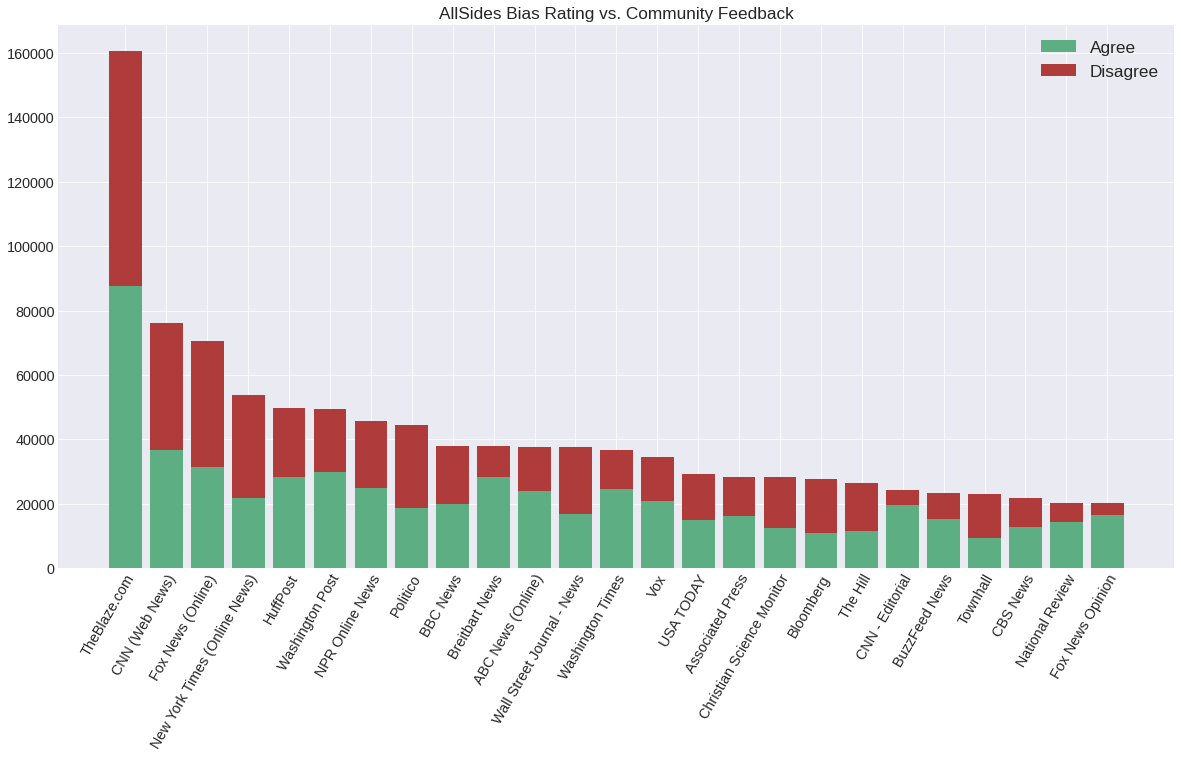

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(df2.index, df2['agree'], color='#5DAF83')
ax.bar(df2.index, df2['disagree'], bottom=df2['agree'], color='#AF3B3B')

ax.set_ylabel = 'Total feedback'

plt.yticks(fontsize='x-large')
plt.xticks(rotation=60, ha='right', fontsize='x-large', rotation_mode='anchor')

plt.legend(['Agree', 'Disagree'], fontsize='xx-large')
plt.title('AllSides Bias Rating vs. Community Feedback', fontsize='xx-large')
plt.show()